### Linking to the google drive to access any data or files

In [ ]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Add the custom module path to sys.path to allow for imports from that directory
import sys
sys.path.append('/content/drive/MyDrive/main/src/')

### Importing the helper functions

In [ ]:
# Automatically reload modules when they change
%load_ext autoreload
%autoreload 2

# Import necessary custom modules and functions
from train import train_model
from model import initialise_model
from utils import set_requires_grad, save_model
from data import load_data
from plotting import plot_data_loader
from eval import eval_model

### Importing the required libraries

In [ ]:
# Import standard libraries
import os
import copy
import time
import random
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm import tqdm

# Import sklearn and metrics for evaluation
from sklearn.metrics import f1_score, confusion_matrix
from numpy.random import shuffle

# Import PyTorch and torchvision libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as td
import torchvision.transforms as T
from torchvision.io import read_image
import torch.autograd.profiler as tprofiler
from torchvision import datasets, models, transforms

# Configure Matplotlib to automatically adjust the figure size when saving plots
plt.rcParams["savefig.bbox"] = 'tight'

### Setting up the seed and directories

In [ ]:
# Set a fixed seed for reproducibility
seed = 26

random.seed(seed)  # Set the seed for the random module

# Set the seed for PyTorch to ensure reproducibility in its operations
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  # Ensures reproducibility in cuDNN
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # Set the seed for all GPUs if CUDA is available

# Set the seed for NumPy to ensure reproducibility in its operations
np.random.seed(seed)

# Set the directories for data and images
data_dir = "/content/drive/MyDrive/data"
images_dir = "/content/drive/MyDrive/data/covid_pneumonia"

### Setting up the model and the required variables

In [ ]:
# Choose the model architecture for this run
model_name = "mobile_net_v3_large"

# Number of output classes. Adjust based on your classification task.
num_classes = 3

# Batch size for training and validation. Larger batch sizes require more memory.
batch_size = 32

# Number of epochs to train the model. Adjust based on overfitting/underfitting considerations.
num_epochs = 50

# Number of subprocesses to use for data loading. Adjust based on your CPU capabilities.
num_workers = 12

# Normalisation parameters for the datasets (mean and standard deviation).
norm_arr = ([0.5159, 0.5159, 0.5159], [0.2554, 0.2554, 0.2554])

# Feature extraction flag: If True, only update the final layer parameters.
# If False, update all parameters of the model.
feature_extract = False

# Use pretrained weights: Set to None for random initialization or a string to use specific pretrained weights.
use_pretrained = None

# Initialize the model with the specified settings.
model_pyt, input_size = initialise_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)

# Learning rate start and end points for training. Learning rate can be adjusted based on the optimizer used.
lr_start = 0.01
lr_end = 0.001

# Number of epochs after which learning rate restarts (restarts training from a higher learning rate).
iter_restart = 10

# Multiplication factor after each restart of learning rate.
mul_restart = 1

### Loading the data

In [ ]:
# Load the data with appropriate transformations and normalization.
data_loaders = load_data(images_dir,
                         batch_size=batch_size,
                         input_size=input_size,
                         norm_arr=norm_arr,
                         num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Checking for GPU and determining parameters

In [ ]:
# Check if GPU is available, otherwise fall back to CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device selected: {device}")

# Send the model to the appropriate device (GPU or CPU).
model_pyt = model_pyt.to(device)

# Determine which parameters will be updated during training.
params_to_update = model_pyt.parameters()
print("Parameters to learn:")
if feature_extract:
    # If feature extraction is enabled, only update the final layer parameters.
    params_to_update = []
    for name, param in model_pyt.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print(f"\t{name}")
else:
    # If feature extraction is disabled, update all parameters.
    for name, param in model_pyt.named_parameters():
        if param.requires_grad:
            print(f"\t{name}")

Device selected: cuda:0
Parameters to learn:
	features.0.0.weight
	features.0.1.weight
	features.0.1.bias
	features.1.block.0.0.weight
	features.1.block.0.1.weight
	features.1.block.0.1.bias
	features.1.block.1.0.weight
	features.1.block.1.1.weight
	features.1.block.1.1.bias
	features.2.block.0.0.weight
	features.2.block.0.1.weight
	features.2.block.0.1.bias
	features.2.block.1.0.weight
	features.2.block.1.1.weight
	features.2.block.1.1.bias
	features.2.block.2.0.weight
	features.2.block.2.1.weight
	features.2.block.2.1.bias
	features.3.block.0.0.weight
	features.3.block.0.1.weight
	features.3.block.0.1.bias
	features.3.block.1.0.weight
	features.3.block.1.1.weight
	features.3.block.1.1.bias
	features.3.block.2.0.weight
	features.3.block.2.1.weight
	features.3.block.2.1.bias
	features.4.block.0.0.weight
	features.4.block.0.1.weight
	features.4.block.0.1.bias
	features.4.block.1.0.weight
	features.4.block.1.1.weight
	features.4.block.1.1.bias
	features.4.block.2.fc1.weight
	features.4.b

### Training the model

In [ ]:
# Set up the optimizer with the selected parameters and initial learning rate.
optimizer = optim.Adam(params_to_update, lr=lr_start)

# Set up a learning rate scheduler with cosine annealing (gradually decreases the learning rate).
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=lr_end, last_epoch=-1)

# Define the loss function (criterion) for multi-class classification.
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_pyt, val_history, train_history = train_model(device, model_pyt, data_loaders,
                                                            optimizer, scheduler,
                                                            criterion,
                                                            num_epochs=num_epochs,
                                                            num_classes=num_classes,
                                                            early_stopping_patience=5,  # Stop if no improvement after 5 epochs
                                                            min_delta=0.001  # Consider only significant improvements
                                                            )

Epoch 1/50
----------
Epoch [1/50], Step [100/188], Loss: 0.7467, Accuracy: 0.56%
Train Loss: 1.0543 Acc: 0.4984
Val Loss: 1.2236 Acc: 0.4219

Epoch 2/50
----------
Epoch [2/50], Step [100/188], Loss: 0.7409, Accuracy: 0.59%
Train Loss: 0.7290 Acc: 0.6495
Val Loss: 1.6523 Acc: 0.3800

Epoch 3/50
----------
Epoch [3/50], Step [100/188], Loss: 0.8214, Accuracy: 0.62%
Train Loss: 0.6223 Acc: 0.7200
Val Loss: 1.5701 Acc: 0.5843

Epoch 4/50
----------
Epoch [4/50], Step [100/188], Loss: 0.5109, Accuracy: 0.78%
Train Loss: 0.5839 Acc: 0.7380
Val Loss: 4.4078 Acc: 0.3520

Epoch 5/50
----------
Epoch [5/50], Step [100/188], Loss: 0.5248, Accuracy: 0.81%
Train Loss: 0.5145 Acc: 0.7789
Val Loss: 2.6261 Acc: 0.4514

Epoch 6/50
----------
Epoch [6/50], Step [100/188], Loss: 0.5562, Accuracy: 0.75%
Train Loss: 0.4708 Acc: 0.8009
Val Loss: 0.6922 Acc: 0.7047

Epoch 7/50
----------
Epoch [7/50], Step [100/188], Loss: 0.7236, Accuracy: 0.66%
Train Loss: 0.4327 Acc: 0.8194
Val Loss: 1.4991 Acc: 0.6162


### Saving the model for future use

In [ ]:
# Define the dataset name for saving files
dataset_name = 'covid_pneumonia'

# Save the trained model's weights to a file in the specified directory
save_model(model_pyt, '/content/drive/MyDrive/models/',
           f'{model_name}_{num_epochs}_model_weights.pth')

True

### Evaluating the model

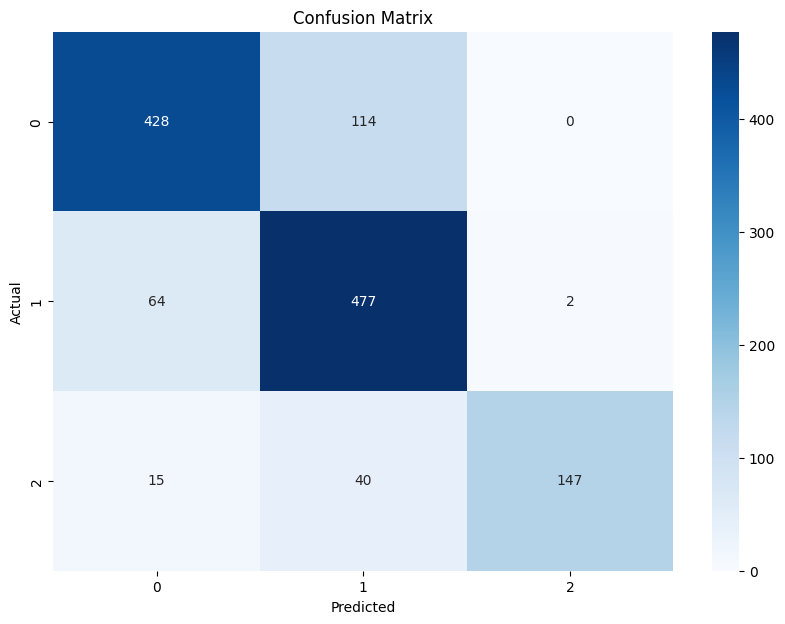

In [ ]:
# Evaluate the model using the test dataset and store the evaluation metrics
eval_metrics = eval_model(device=device, model=model_pyt, test_loader=data_loaders['test'])

In [ ]:
# Print the evaluation metrics
for metric_name, metric_value in eval_metrics.items():
    print(f"{metric_name}: {metric_value}")

acc: 0.8174048174048174
f1: 0.8220761879409769
precision: 0.8622338628253964
recall: 0.7986145692100758
cm: [[428 114   0]
 [ 64 477   2]
 [ 15  40 147]]
roc_auc: 0.9229858059426673
outputs: [1 0 0 ... 2 2 2]
targets: [0 0 0 ... 2 2 2]


### Saving the history

In [ ]:
# Save the validation history to a pickle file
with open(f'/content/drive/MyDrive/models/val_history_{model_name}_{num_epochs}.pickle', 'wb') as handle:
    pickle.dump(val_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the training history to a pickle file
with open(f'/content/drive/MyDrive/models/train_history_{model_name}_{num_epochs}.pickle', 'wb') as handle:
    pickle.dump(train_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the evaluation metrics to a pickle file
with open(f'/content/drive/MyDrive/models/eval_metrics_{model_name}_{num_epochs}.pickle', 'wb') as handle:
    pickle.dump(eval_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)